# Tests of the implementation

In [13]:
%reset -f
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os, sys, glob, matplotlib, rmsd
import numpy as np
%matplotlib widget

import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-2, 2))
plt.rcParams.update({'font.size': 14})  

from ase.io import read

sys.path.insert(0, '../pypi_repo_round2/src/')  # WIP: Remove when in pypi
from grsq.grsq import RDF, RDFSet, rdfset_from_dir
from grsq.damping import Damping
from grsq.debye import Debye

def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import grsq

grsq.__file__

'/home/jupyter-asod/.local/lib/python3.9/site-packages/grsq/__init__.py'

## 2 Particle Solute 
Identical atom types. RDFs generated using `vmd`

2
2


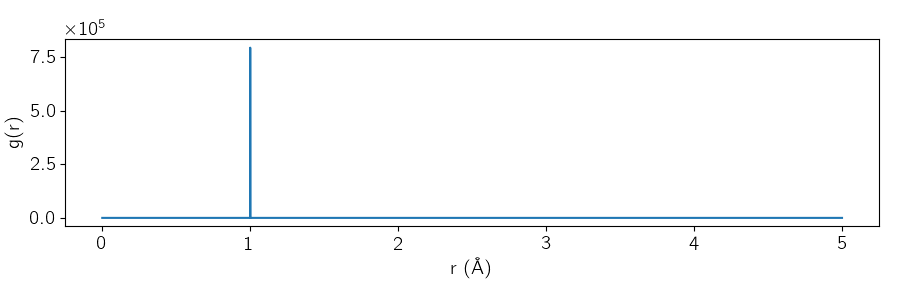

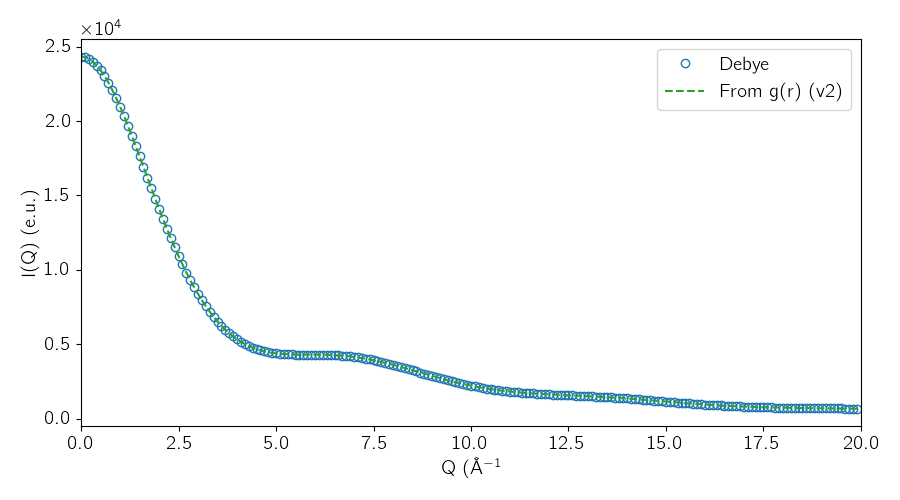

In [17]:
atoms = read('data/test/xray_2particle/test.xyz')
deb = Debye(qvec=np.arange(0, 20, 0.01))
i_deb = deb.debye(atoms)

stoich = {'Pt_u':2}
V = 10**3

rdf_dat = np.genfromtxt('data/test/xray_2particle/gPt_u-Pt_u.dat')

rdf = RDF(rdf_dat[:, 0], rdf_dat[:, 1], 'Pt', 'Pt', 'solute', 'solute', qvec=deb.qvec)
rdf.n1 = 2
rdf.n2 = 2
rdf.volume = V

iq = rdf.i_term1()
iq += rdf.i_term2()

fig, ax = plt.subplots(1, 1, figsize=(9, 3)) 
ax.plot(rdf_dat[:, 0 ], rdf_dat[:, 1])
ax.set_ylabel('g(r)')
ax.set_xlabel('r (Å)')
fig.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec[::10], i_deb[::10], 'C0o', label='Debye', mfc='None')
ax.plot(rdf.qvec,  iq, 'C2--', label='From g(r) (v2)')

ax.set_xlim([0, 20])
ax.set_xlabel('Q (Å$^{-1}$')
ax.set_ylabel('I(Q) (e.u.)')
ax.legend(loc='best');
fig.tight_layout()



In [25]:
rdf.structure_factor()
rdf.vdv_correct()

array([3.00000015, 2.99996681, 2.99986681, ..., 1.09020361, 1.09058877,
       1.09096448])

### 3 Particle system again, using the RDFSet() class
Pt, Pt, Ar. Artificial system, to check book-keeping. 

The RDF needs to be finely sampled for the discrete and density-based formulation to be numerically equal, hence the somewhat long calculation time.

In [18]:
rdfs = rdfset_from_dir('data/test/xray_3particle/', 
                       'data/test/xray_3particle/ptptar.xyz', volume=10**3)
rdfs.show()

|  #  | KEY                     |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | Ar-solute--Pt-solute    | N1:     1, N2:     2 | solute , solute  | 1000.0000 |
| 001 | Pt-solute--Ar-solute    | N1:     2, N2:     1 | solute , solute  | 1000.0000 |
| 002 | Pt-solute--Pt-solute    | N1:     2, N2:     2 | solute , solute  | 1000.0000 |


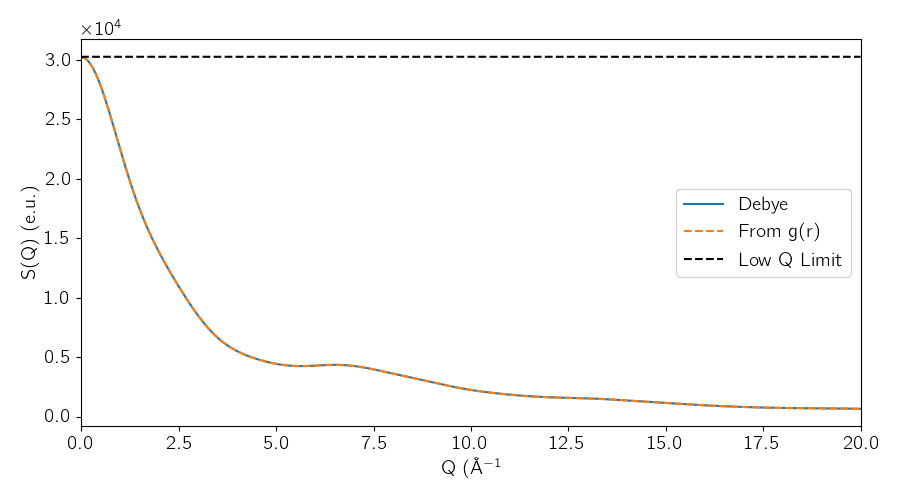

In [19]:
qvec = np.arange(0, 20, 0.01)

atoms = read('data/test/xray_3particle/ptptar.xyz')
deb = Debye(qvec=qvec)
i_deb = deb.debye(atoms)
num_electrons_squared = sum(atoms.get_atomic_numbers())**2

i_g = rdfs.get_iq(qvec)

fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, i_deb, 'C0', label='Debye')
ax.plot(qvec, i_g, 'C1--', label='From g(r)')
ax.plot(qvec, np.ones_like(qvec) * num_electrons_squared, 'k--', label='Low Q Limit')
ax.set_xlim([0, 20])
ax.set_xlabel('Q (Å$^{-1}$')
ax.set_ylabel('S(Q) (e.u.)')
ax.legend(loc='best');
fig.tight_layout()

### Scattering from one of of the larger molecules in ../data

RDFs generated using vmd: `vmd -dipsdev none -e -eofexit ../data/test/xray_agptpop/get_rdfs.tcl` 

In [32]:
rdfs = rdfset_from_dir('data/test/xray_agptpop/', 'data/test/xray_agptpop/agptpop_dry.prmtop', volume=25**3)
rdfs.show()

/opt/tljh/user/envs/py38/lib/python3.8/site-packages/MDAnalysis/core/universe.py:159: UserWarning: No coordinate reader found for data/test/xray_agptpop/agptpop_dry.prmtop. Skipping this file.
  warnings.warn('No coordinate reader found for {}. Skipping '


|  #  | KEY                   |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | Ag-solute--H-solute   | N1:     1, N2:     8 | solute , solute  | 15625.0000 |
| 001 | Ag-solute--O-solute   | N1:     1, N2:    20 | solute , solute  | 15625.0000 |
| 002 | Ag-solute--P-solute   | N1:     1, N2:     8 | solute , solute  | 15625.0000 |
| 003 | Ag-solute--Pt-solute  | N1:     1, N2:     2 | solute , solute  | 15625.0000 |
| 004 | H-solute--Ag-solute   | N1:     8, N2:     1 | solute , solute  | 15625.0000 |
| 005 | H-solute--H-solute    | N1:     8, N2:     8 | solute , solute  | 15625.0000 |
| 006 | H-solute--O-solute    | N1:     8, N2:    20 | solute , solute  | 15625.0000 |
| 007 | H-solute--P-solute    | N1:     8, N2:     8 | solute , solute  | 15625.0000 |
| 008 | H-solute--Pt-solute   | N1:     8, N2:     2 | solute , solute  | 15625.0000 |
| 009 | O-solute--Ag-solute   | N1:    20, N2:     1 | solute , solute  | 15625.0000 |
| 010 | O-solute--H-solute    | N1:    20, N2:  

In [33]:
qvec = np.arange(0, 10, 0.1)

atoms = read('data/test/xray_agptpop/agptpop_dry.xyz')
deb = Debye(qvec=qvec)
iq_deb = deb.debye_numba(atoms)
num_electrons_squared = sum(atoms.get_atomic_numbers())**2

iq_rdf = rdfs.get_iq(qvec=qvec)


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  0%|          | 0/24 [00:00<?, ?it/s]

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec, iq_deb, 'C0', label='Debye')
ax.plot(deb.qvec, iq_rdf, 'C1--', label='From g(r')
ax.plot(deb.qvec, np.ones_like(deb.qvec) * num_electrons_squared, 'k--', label='Low Q Limit')
ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('S(Q) (e.u.)')
ax.legend(loc='best');
fig.tight_layout()

The remaining difference scales linearly with dr in the RDF-sampling. You can check this by changing the `dr`in the vmd script and rerun the RDF sampling. 

However, smaller `dr` than the current value of 0.0001 makes the calculation _really_ slow, and the numerical integration (simply `sum * dr`) isn't good enough

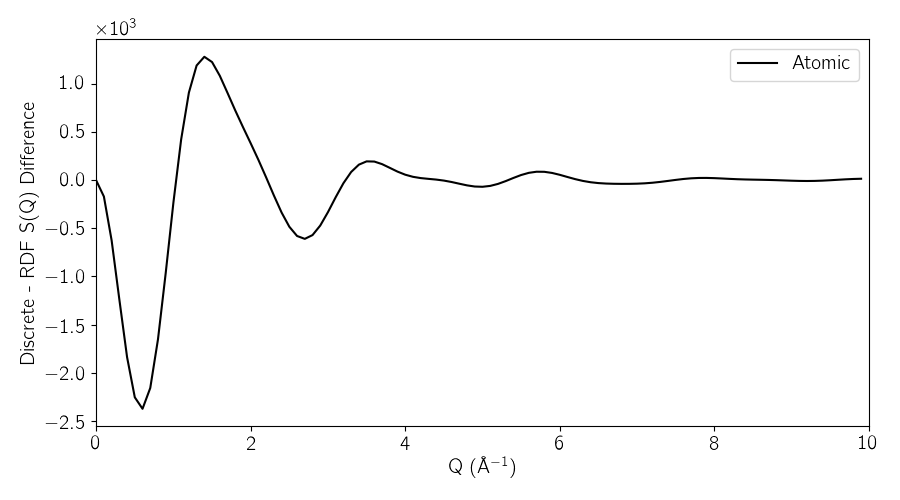

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec, iq_deb - iq_rdf, 'k-', label='Atomic')
ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('Discrete - RDF S(Q) Difference')
ax.legend(loc='best');
fig.tight_layout()


### Water from VMD RDFs

These are normalized with (10.1016/j.jcp.2011.01.048) 

$$
\rho = \frac{N - \delta_{lm}}{V}
$$

Which results in the van der Vegt correction not requiring to add back the particle we start from, in the $\Delta N_{lm}(r)$ term

In [171]:
rdfs = rdfset_from_dir('data/test/xray_water/', 'data/test/xray_water/waterbox_04096_amber.prmtop')
rdfs.show()

|  #  | KEY                     |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | H-solvent--H-solvent    | N1:  8190, N2:  8190 | solvent, solvent | 122900.8521 |
| 001 | H-solvent--O-solvent    | N1:  8190, N2:  4095 | solvent, solvent | 122900.8521 |
| 002 | O-solvent--H-solvent    | N1:  4095, N2:  8190 | solvent, solvent | 122900.8521 |
| 003 | O-solvent--O-solvent    | N1:  4095, N2:  4095 | solvent, solvent | 122900.8521 |


In [103]:
V = 122900.85207774633
stoich = {'H_v': 8190, 'O_v': 4095}
qvec = np.arange(0, 10, 0.05)

rdfs = rdfset_from_dir('data/test/xray_water/', volume=V, stoich=stoich)
ig_s = rdfs.get_solvent(qvec)  # using solvent-only function
ig_a = rdfs.get_iq(qvec)       # using total scat 
rdfs.vdv_correct()
igc_s = rdfs.get_solvent()     # solvent-only, corrected

fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, ig_s)
ax.plot(qvec, ig_a)
ax.plot(qvec, igc_s)
np.save('watertest.npy', (ig_s, ig_a, igc_s))

Corrections

In [31]:
import copy
qvec = np.arange(0, 10, 0.01)
corrected_set = copy.deepcopy(rdfs)
corrected_set.vdv_correct()   
iq_rdf_corr = corrected_set.get_iq(qvec=qvec)
sg_2 = rdfs.get_iq(qvec=qvec)
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, sg_2, 'C0-', label='From g(r)')
ax.plot(qvec, iq_rdf_corr, 'C1--', label='Corrected')
ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('I(Q)')
ax.legend(loc='best');
fig.tight_layout()

In [52]:
from scipy.integrate import cumtrapz
rdf = copy.deepcopy(rdfs)[3]
rdf.vdv_correct()
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(rdf.r, rdf.fac)
ax.set_xlabel('r (Å)')
ax.set_ylabel('VDV Factor (r)')
ax.set_xlim([0, 25])

(0.0, 25.0)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

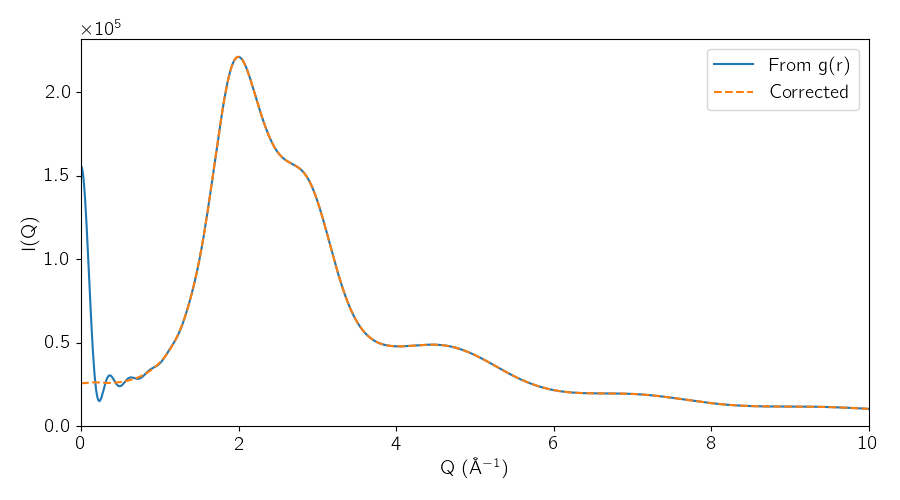

In [19]:
import copy

qvec = np.arange(0, 10, 0.01)
r_max = rdfs[0].r[-1]

corrected_set = RDFSet()
for key, rdf in rdfs.items():
    rdf_vc = copy.deepcopy(rdf)
    rdf_vc.g = rdf_vc.vdv_correct()
    rdf_vc.r_max = r_max
    rdf_vc.damp = Damping('zederkof', r_max=r_max, r_cut=r_max-1)# None #Damping('lorch', L=r_max)
    corrected_set[key] = rdf_vc
    
iq_rdf_corr = corrected_set.get_iq(qvec=qvec)
qvec = np.arange(0, 10, 0.01)

sg_2 = rdfs.get_iq(qvec=qvec)
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, sg_2, 'C0-', label='From g(r)')
ax.plot(qvec, iq_rdf_corr, 'C1--', label='Corrected')
ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('I(Q)')
ax.legend(loc='best');
fig.tight_layout()

### Water from MDAnalysis RDFs

In contrast, are normalized with (see the source code):

$$
\rho = \frac{N}{V}
$$

Which results in the van der Vegt correction as it is written up originally (see 10.1021/ct301017q).

In [4]:
rdfs = rdfset_from_dir('../Water_MDA_RDFs/', 'data/test/xray_water/waterbox_04096_amber.prmtop')
rdfs.show()

/opt/tljh/user/envs/py38/lib/python3.8/site-packages/MDAnalysis/topology/TOPParser.py:295: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(msg)
/opt/tljh/user/envs/py38/lib/python3.8/site-packages/MDAnalysis/core/universe.py:159: UserWarning: No coordinate reader found for data/test/xray_water/waterbox_04096_amber.prmtop. Skipping this file.
  warnings.warn('No coordinate reader found for {}. Skipping '


|  #  | KEY                   |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | H-solvent--H-solvent  | N1:  8190, N2:  8190 | solvent, solvent | 122900.8521 |
| 001 | H-solvent--O-solvent  | N1:  8190, N2:  4095 | solvent, solvent | 122900.8521 |
| 002 | O-solvent--H-solvent  | N1:  4095, N2:  8190 | solvent, solvent | 122900.8521 |
| 003 | O-solvent--O-solvent  | N1:  4095, N2:  4095 | solvent, solvent | 122900.8521 |


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

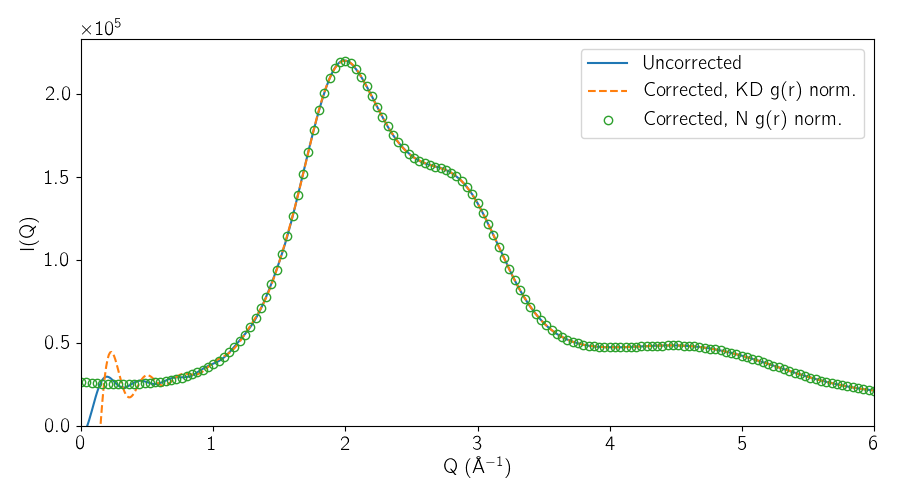

In [20]:
import copy

qvec = np.arange(0, 10, 0.01)
r_max = rdfs[0].r[-1]

sg_2 = rdfs.get_iq(qvec=qvec)
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, sg_2, 'C0-', label='Uncorrected')

linestyles = ('--', 'o')
for i, rho_norm in enumerate(['KD', 'N']):
    corrected_set = RDFSet()
    for key, rdf in rdfs.items():
        rdf.rho_norm = rho_norm
        rdf_vc = copy.deepcopy(rdf)
        rdf_vc.g = rdf_vc.vdv_correct()
        rdf_vc.r_max = r_max
        rdf_vc.damp = Damping('zederkof', r_max=r_max, r_cut=r_max-1)# None #Damping('lorch', L=r_max)
        corrected_set[key] = rdf_vc

    iq_rdf_corr = corrected_set.get_iq(qvec=qvec)
    qvec = np.arange(0, 10, 0.01)
    ax.plot(qvec[::i*3 + 1], iq_rdf_corr[::i*3 + 1], f'C{1 + i}{linestyles[i]}', label=f'Corrected, {rho_norm} g(r) norm.', mfc='none')

ax.set_xlim([0, 6])
ax.set_ylim([0, 2.33e5])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('I(Q)')
ax.legend(loc='best');
fig.tight_layout()

## All corrections, all dampings

1.4213563705045986 0.822914248493976
0.0 0.4734868077309238
0.0 0.4734868077309238
1.8599439939218725 1.8711965707831326


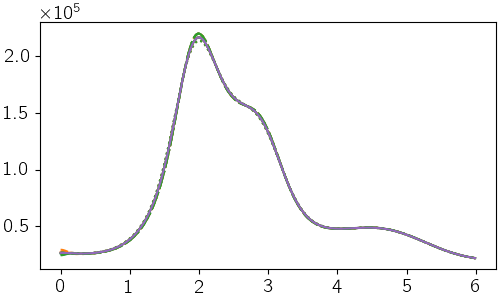

In [3]:
import copy 
V = 122900.85207774633
stoich = {'H_v': 8190, 'O_v': 4095}
rdfs_raw = rdfset_from_dir('../pypi_repo_round2/tests/data/mda_water/', volume=V, stoich=stoich)
#rdfs_raw = rdfset_from_dir('../Water_MDA_RDFs/', volume=V, stoich=stoich)
#rdfs_raw = rdfset_from_dir('../Water_MDA_RDFs/', 'data/test/xray_water/waterbox_04096_amber.prmtop')
r_max = rdfs_raw[0].r[-1]

lrh = Damping('lorch', L=r_max)
zkf = Damping('zederkof', r_max=r_max, r_cut=r_max-1)
dhb = Damping('dhabal', r_max=r_max)
fad = Damping('panman', L=10)
dampings = [lrh, zkf, dhb, fad]
corrections = ('volume', 'perera', 'vegt')

qvec = np.arange(0, 6, 0.01)

lines = ['-', '--', ':', '-.']
dnames = ['Lorch', 'ZK', 'Dhabal', 'Fade']

results = np.zeros((len(qvec), 12))

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 3))
ct = 0
for c, corr in enumerate(corrections):
    for d, damp in enumerate(dampings):
        rdfs = copy.deepcopy(rdfs_raw)
        for rdf in rdfs.values():
            rdf.rho_norm = 'N'
            r_first_nonzero = rdf.r[np.where(rdf.g > 0)[0]][0]
            r_c = r_first_nonzero - 0.5
            corr_vars = ({'Ri':r_c}, {'Ri':r_first_nonzero, 'R_avg':10.6579}, {})
            rdf.g = rdf.correct(method=corr, **(corr_vars[c]))
            rdf.damp = damp

        iq = rdfs.get_solvent(qvec=qvec)
        ax.plot(qvec, iq, f'C{c}{lines[d]}', label=corrections[c].title() + f' {dnames[d]}')
        results[:, ct] = iq
        ct += 1

# also use the fit of the volume
rdfs = copy.deepcopy(rdfs_raw)
for rdf in rdfs.values():
    rdf.rho_norm = 'N'
    r_first_nonzero = rdf.r[np.where(rdf.g > 0)[0]][0]
    r_c = r_first_nonzero - 0.5
    opt = rdf.fit(r_c, fit_start=15, fit_stop=r_max)
    print(opt.x[0], r_c)
    rdf.g = rdf.correct(method='volume', Ri=opt.x[0])
    rdf.damp = lrh
iq = rdfs.get_solvent(qvec=qvec)
ax.plot(qvec, iq, f'C4', label='Fitted Volume')    

#ax.legend(loc='best')


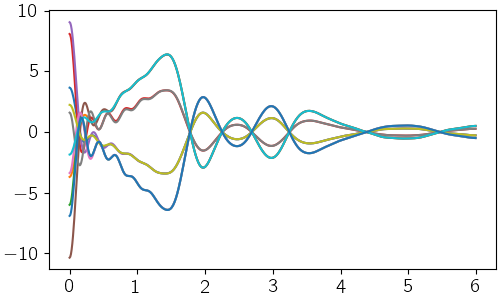

In [214]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 3))

ax.plot(qvec, 100 * np.diff(results, axis=-1) / np.mean(results, axis=-1)[:, None])


In [215]:
np.max(np.abs(np.diff(results, axis=-1) / np.mean(results, axis=-1)[:, None]))

0.1037241057078821

# Tests of the discrete Debye implementations

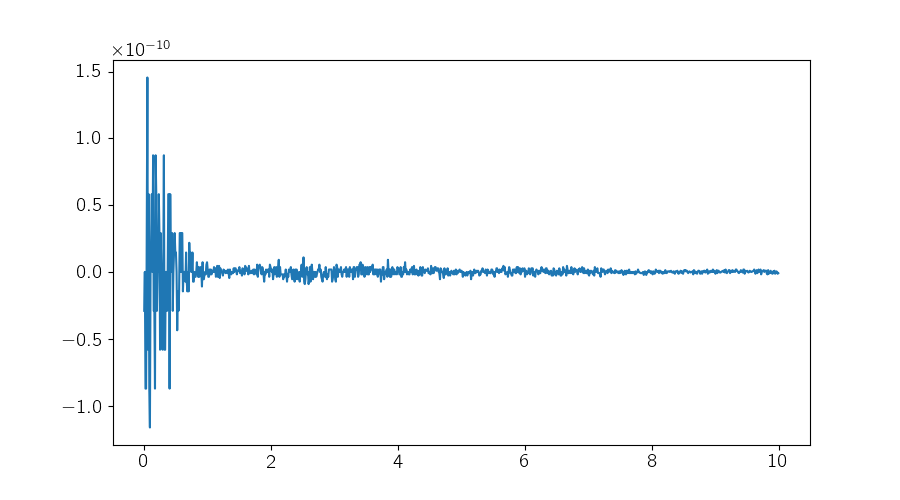

In [4]:
from ase import Atoms
fw_atoms = read('../pypi_repo_round2/tests//data/testmol.xyz')
syms = fw_atoms.get_chemical_symbols()
syms.reverse()
rw_atoms = Atoms(''.join(syms), positions=np.flip(fw_atoms.positions))
deb = Debye()
s_fw = deb.debye(fw_atoms)
s_rw = deb.debye(rw_atoms)
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec, s_fw- s_rw)


5.942183634033427e-09


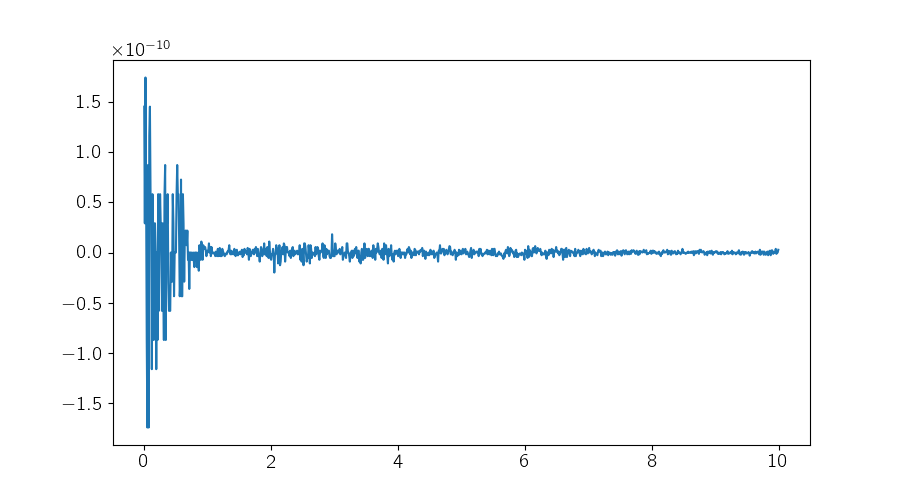

In [2]:
''' Test that the Debye and numba implementations give the same result '''
atoms = read('../pypi_repo_round2/tests/data/testmol.xyz')
deb = Debye()
slow = deb.debye(atoms)
fast = deb.debye_numba(atoms)
#assert np.sum(np.abs(slow - fast)) < 1e-8
print(np.sum(np.abs(slow - fast)))
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec, fast- slow)
#ax.plot(deb.qvec, )

### Tests of DV and cross

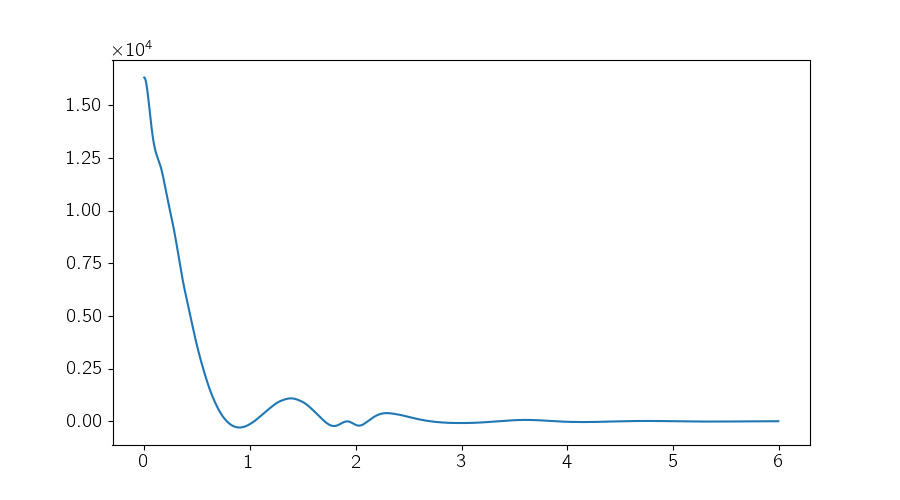

In [32]:
qvec = np.arange(0, 6, 0.005)
def get_data(fdir):
    uv_files = sorted(glob.glob(fdir + '/*gAr_u-Ar_v.dat'))
    vv_files = sorted(glob.glob(fdir + '/*gAr_v-Ar_v.dat'))
    out = []
    for files in (uv_files, vv_files):
        tmp = np.genfromtxt(files[0])
        rdfs = np.zeros((tmp.shape[0], tmp.shape[1], len(files)))
        for f, fil in enumerate(files):
            dat = np.genfromtxt(fil)
            rdfs[:, :, f] = dat
        out.append(np.mean(rdfs, axis=-1))
    return out

dat = get_data('../pypi_repo_round2/tests/data/xray_lj/')


V = 100**3
rdf_uv = RDF(r=dat[0][:, 0], g=dat[0][:, 1], 
                name1='Ar', name2='Ar', region1='solute', region2='solvent', 
                n1=1, n2=20712, volume=V, qvec=qvec)

rdf_vv = RDF(r=dat[1][:, 0], g=dat[1][:, 1], 
                name1='Ar', name2='Ar', region1='solvent', region2='solvent', 
                n1=20712, n2=20712, volume=V, qvec=qvec)

rdfs = RDFSet()

rdfs.add_rdf(rdf_uv)
rdfs.add_flipped(rdf_uv)
rdfs.add_rdf(rdf_vv)
rdfs.vdv_correct()

cross = rdfs.get_cross(qvec=qvec)
dispv = rdfs.get_dv(qvec=qvec)

fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, cross + dispv)
np.save('../pypi_repo_round2/tests/data/xray_lj/cross.npy', cross)
np.save('../pypi_repo_round2/tests/data/xray_lj/dv.npy', dispv)

In [38]:
cross_clc = cross
dispv_clc = dispv
cross_ref = np.load('../pypi_repo_round2/tests/data/xray_lj/cross.npy')
dispv_ref = np.load('../pypi_repo_round2/tests/data/xray_lj/dv.npy')

np.sum(np.abs(dispv_clc - dispv_ref)) 

0.0